In [1]:
import geopandas as gpd
import shapely
from matplotlib import pyplot as plt
import numpy as np

In [2]:
voies = gpd.read_file(r"Donnees_filtrees\Data\voirie_mask.shp").to_crs(epsg=2154)
mask = gpd.read_file(r"Donnees_filtrees\Data\Part_Dieu_buffer_1km.shp")

On commence par importer les voies et le masque de la zone à traiter

<AxesSubplot:>

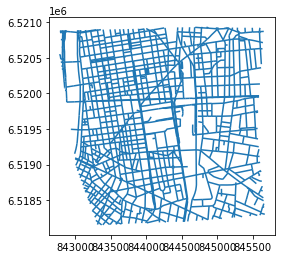

In [3]:
voies.plot()

In [4]:
bat = gpd.read_file(r"data\buildings.shp").to_crs(epsg=2154)
arbres = gpd.read_file('data/arbres_alignement_mask.shp').to_crs(epsg=2154)

Les couches des batiments et des arbres nous intéressent aussi (elles ont déjà été traitées pour la zone en question)

In [5]:
from t4gpd.morph.STDensifier import STDensifier

sensors = STDensifier(voies, distance=10, adjustableDist=False, removeDuplicate=True).run()

On utilise l'outil de calcul des zones des isovist de t4gpd sur les points issues des voiries

In [6]:
"""
from t4gpd.isovist.STIsovistField2D import STIsovistField2D
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess

_, isov = STIsovistField2D(bat, sensors, nRays=100, rayLength=50.0).run()

isov.to_file('isov.shp', driver = 'ESRI Shapefile')
"""

"\nfrom t4gpd.isovist.STIsovistField2D import STIsovistField2D\nfrom t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess\n\n_, isov = STIsovistField2D(bat, sensors, nRays=100, rayLength=50.0).run()\n\nisov.to_file('isov.shp', driver = 'ESRI Shapefile')\n"

On recharge la couche isov calculée précédement

In [7]:
isov = gpd.read_file(r'isov.shp').to_crs(epsg=2154)

[]

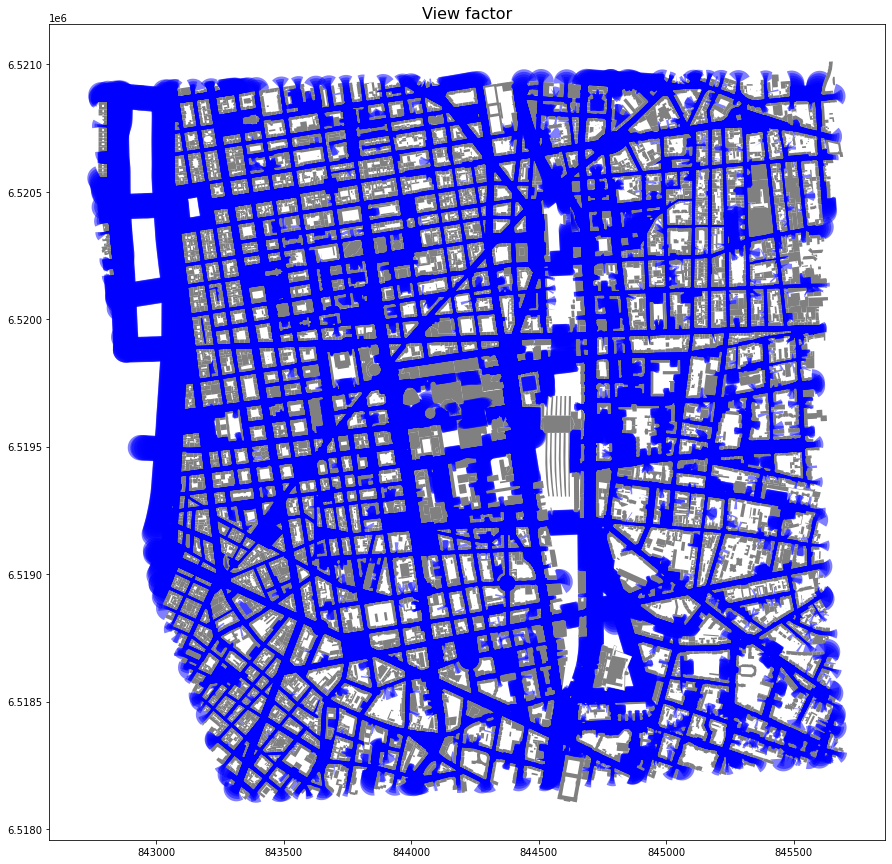

In [8]:
_, basemap = plt.subplots(figsize = (15,15 ))
basemap.set_title('View factor', fontsize=16)
bat.plot(ax=basemap, color='grey')
isov.plot(ax=basemap, color='blue', alpha=0.5)
plt.plot()

On observe les différentes zonnes considérées comme visibles, sans prendre un compte la topologie.
Comme on se place sur les voieries, l'espace d'étude est restrint à ce qui est visible depuis l'espace public uniquement

Il faut maintenant compter le nombre d'arbres pour chaque point de l'indicateur

In [9]:
arbres.geometry=arbres.geometry.centroid

In [10]:
from shapely.geometry import Point
arbres['point'] = arbres.geometry.apply(lambda p: p.centroid)
arbres = arbres.set_geometry('point')

On utilise join pour trouver tous les arbres intersectant chaque aire d'isovist 

In [11]:
test = gpd.sjoin(isov, arbres, how='left', op='intersects')

In [ ]:
liste = {}
for i in range(len(test)):
    key = int(test['gid_left'][i:i+1])
    if (key in liste):
        liste[key]+=1
    else:
        liste[key]=1
        
l = []
for cle, i in liste.items():
    l.append(i)

In [ ]:
import pandas as pd

m = np.median(l)
s = pd.Series([k/(2*m) for k in l])
isov['tvf'] = s

In [ ]:
isovmap = isov

In [ ]:
isovmap.geometry = sensors.geometry

In [ ]:
_,basemap = plt.subplots(figsize =(20, 20))
plt.axis('off')
plt.title('Tree proximity factor')
isovmap.plot(ax=basemap, cmap ='magma', column='tvf')
arbres.plot(ax=basemap, color = 'green', legend=True)
bat.plot(ax=basemap, legend=True)

In [ ]:
from shapely.geometry import box

roi = box(*bat.total_bounds).buffer(-800)
arbres = gpd.clip(arbres, roi)
bat = gpd.clip(bat, roi)
isov2 = gpd.clip(isov2, roi)

In [ ]:
_,basemap = plt.subplots(figsize =(16, 16))
plt.axis('off')
plt.title('Tree view factor')
isovmap.plot(ax=basemap, cmap ='YlOrBr', column='tvf', linewidth=1)
arbres.plot(ax=basemap, color = 'green', alpha=0.5)
bat.plot(ax=basemap, color='grey')

In [ ]:
isovmap.to_file('isov.shp', driver = 'ESRI Shapefile')